# Cell Type PID

This notebook evaluates PID of the mutual information between bipolar cell subtypes positions inside the mouse Retina.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import pandas as pd
from scipy.special import psi, digamma, gamma
import scipy.spatial as ss
from math import log,pi,exp


In [2]:

def coord_transfer(xcoords, ycoords):
    '''
    computes appropriate [center_shift_x , center_shift_y] valuse so that the origin is 
    shifted to the mean of all coordinates and rotatation theta theta_shift so that 
    theta values are continuous between 0 and 2*pi.
    Input:
    
         xcoords   : array_like Input data X Cartesian Coordinates. 
         ycoords   : array_like Input data Y Cartesian Coordinates. 

    Output:
    
         [center_shift_x , center_shift_y]: The values of the proper coordinate shifts 
                                            so that origin is located in the center of the mass.

         theta_shift  : The value of required rotation so the theta values are continuous.   
    '''
    center_shift_x=np.mean(xcoords)
    center_shift_y=np.mean(ycoords)

    xcoords=xcoords-center_shift_x
    ycoords=ycoords-center_shift_y

    xcoordspi=xcoords>0
    xcoordsni=xcoords<0

    posi=np.argmax(xcoords[xcoordspi]**2+ycoords[xcoordspi]**2)
    negi=np.argmax(xcoords[xcoordsni]**2+ycoords[xcoordsni]**2)


    ymax=ycoords[xcoordspi][posi]
    ymin=ycoords[xcoordsni][negi]
    xmax=xcoords[xcoordspi][posi]
    xmin=xcoords[xcoordsni][negi]

    slope=(ymax-ymin)/(xmax-xmin)
    theta=np.arctan(slope)

    #rotatet the frame so that  first theta does not start from zero, and hence becomes continous
    theta_shift=theta-np.pi/2  
    return [center_shift_x , center_shift_y], theta_shift



In [3]:
def unknee(zp):
    '''
    This function straightens curved parts of the cell positions at the beginning and the end points 
    
    Input:
    
         zp   : array_like Input data, X, Y Cartesian Coordinates. 

    Output:
         zp_out   : array_like straightened Output data, X, Y Cartesian Coordinates .   
    '''
    xp=zp[:,0]
    yp=zp[:,1]
    plt.figure()
    plt.scatter(xp, yp)
    tvalo=np.mod(np.arctan2(yp, xp), 2*np.pi)
    rval_crt=np.argmax(xp[tvalo<np.pi])
    #rval_crt_thr=rval_crt-1
    rval_crt_thr=5
    while(rval_crt>rval_crt_thr):

        xt=(xp[:rval_crt]-xp[rval_crt])
        yt=(yp[:rval_crt]-yp[rval_crt])
        theta_mod=-np.pi/8
        xp[:rval_crt]=xt*np.cos(theta_mod)+yt*np.sin(theta_mod)+xp[rval_crt]
        yp[:rval_crt]=yt*np.cos(theta_mod)-xt*np.sin(theta_mod)+yp[rval_crt]
        tvalo=np.mod(np.arctan2(yp, xp), 2*np.pi)
        sidx=np.argsort(tvalo)
        tvalo=tvalo[sidx]
        rvalo=np.sqrt(yp**2+xp**2)
        rvalo=rvalo[sidx]
        yp, xp=yp[sidx], xp[sidx]
        rval_crt=np.argmax(xp[tvalo<np.pi/2])
        plt.scatter(xp, yp)
    rval_crt=np.argmax(xp[tvalo>np.pi])
    rval_crt=len(xp[tvalo<np.pi])+rval_crt
    xlen=len(xp)
    rval_crt_thr=xlen-5
    #rval_crt_thr=rval_crt
    plt.figure()
    plt.scatter(xp, yp)
    while(rval_crt< rval_crt_thr):

        xt=(xp[rval_crt:]-xp[rval_crt])
        yt=(yp[rval_crt:]-yp[rval_crt])
        theta_mod=np.pi/8
        xp[rval_crt:]=xt*np.cos(theta_mod)+yt*np.sin(theta_mod)+xp[rval_crt]
        yp[rval_crt:]=yt*np.cos(theta_mod)-xt*np.sin(theta_mod)+yp[rval_crt]
        tvalo=np.mod(np.arctan2(yp, xp), 2*np.pi)
        sidx=np.argsort(tvalo)
        tvalo=tvalo[sidx]
        rvalo=np.sqrt(yp**2+xp**2)
        rvalo=rvalo[sidx]
        yp, xp=yp[sidx], xp[sidx]
        rval_crt=np.argmax(xp[tvalo>np.pi])
        rval_crt=len(xp[tvalo<np.pi])+rval_crt

        plt.scatter(xp, yp)
    zp_out=np.vstack([xp,yp]).T
    return  zp_out

joint_probability function computes joint probability of the CDF functions of the (celltype_1, celltype_2,celltype_3) . 

In [4]:
def joint_probability(cpos, Num_Bins=10, p_bins=0):
    '''
     Parameters:
    
         cpos       : array_like Input data , Cartesian coordinates of the three cell types. 
         Num_Bins   : Number of bins used to compute probabilities.
         p_bins     : theta bins used to count cell type numbers, used if mode is set to 'bin'


     Returns:

         f3D      : Joint probability distribution of the three input cell type coordinates.   
         bins     : bins that are used to compute frequency of input values. 
    '''

    tvec1=np.squeeze(cpos[0])
    tvec2=np.squeeze(cpos[1])
    tvec3=np.squeeze(cpos[2])
    len_vec=[len(tvec1), len(tvec2), len(tvec3)]
    len_vec_min=min(len_vec)

    cnt1veca=np.interp(p_bins, tvec1, np.arange(len_vec[0])/(len_vec[0]-1))
    cnt2veca=np.interp(p_bins, tvec2, np.arange(len_vec[1])/(len_vec[1]-1))
    cnt3veca=np.interp(p_bins, tvec3, np.arange(len_vec[2])/(len_vec[2]-1))

        
 

    # Configuring the bins for pdf calculation

    # bins231=[Num_Bins,Num_Bins,Num_Bins]
    bins1=np.interp(np.linspace(tvec1[0], tvec1[-1], Num_Bins), tvec1, np.arange(len_vec[0])/(len_vec[0]-1))
    bins2=np.interp(np.linspace(tvec2[0], tvec2[-1], Num_Bins), tvec2, np.arange(len_vec[1])/(len_vec[1]-1))
    bins3=np.interp(np.linspace(tvec3[0], tvec3[-1], Num_Bins), tvec3, np.arange(len_vec[2])/(len_vec[2]-1))
    bins231=[bins2, bins3, bins1]

    h3D, edges3D = np.histogramdd((cnt2veca, cnt3veca, cnt1veca), bins=bins231)

    return h3D/np.sum(h3D), bins231



pid_compute computes decomposition of the multivariate information for the input distribution of the three cell types.  

In [5]:
def pid_compute(f3D):
    '''
     Parameters:
         f3D   : Joint probability distribution of the three input cell type coordinates.

     Returns:

         I_Rdncy : Redundancy information between cell type 2 and 3 about cell type 1. 
         I21U         : Unique information of cell type 2 about cell type 1.  
         I31U         : Unique information of cell type 2 about cell type 1.
         I_Snrgy    : Synergistic information between cell type 2 and 3 about cell type 1. 
    '''
    # marginal pdf of cell type 1, 2, 3
    f3D_11=np.sum(np.sum(f3D, axis=0), axis=0)
    f3D_12=np.sum(np.sum(f3D, axis=1), axis=1)
    f3D_13=np.sum(np.sum(f3D, axis=0), axis=1)
    # joint marginal pdf of cell type (1, 2), (1,3), and (2, 3)
    f3D_2D31=np.sum(f3D, axis=0)
    f3D_2D21=np.sum(f3D, axis=1)
    f3D_2D23=np.sum(f3D, axis=2)

    # multiplication of the marginal pdf of cell type (1, 2), (1,3), and (2, 3). 
    # these valuse should be equal to their jointly computed counterparts if the cell type locations are independent. 
    fmul_2D21 = np.outer(f3D_12, f3D_11) 
    # Zero valuse are set to one, so that they are automatically discarded in the computations
    fmul_2D21[fmul_2D21==0]=1  
    fmul_2D31 = np.outer(f3D_13, f3D_11) 
    fmul_2D31[fmul_2D31==0]=1  
    fmul_2D23 = np.outer(f3D_12,f3D_13)   
    fmul_2D23[fmul_2D23==0]=1  

    # PID valused are computed based on the scheme presented in (Paul L. Williams, and Randall D. Beer, 2010)

    divt=np.divide(f3D_2D21,fmul_2D21)
    # Zero valuse are set to one, so that they are automatically discarded in the computations
    divt[divt==0]=1
    I12M=np.multiply(f3D_2D21,np.log2(divt))
    I12S=np.sum(I12M, axis=0)
    I12=np.sum(I12S)

    divt=np.divide(f3D_2D31,fmul_2D31)
    divt[divt==0]=1
    I13M=np.multiply(f3D_2D31,np.log2(divt))
    I13S=np.sum(I13M, axis=0) 

    I13=np.sum(I13S) 

    fmul_3D=np.multiply.outer(f3D_2D23, f3D_11)
    fmul_3D[fmul_3D==0]=1
    divt=np.divide(f3D,fmul_3D)
    divt[divt==0]=1
    I23_1M=np.multiply(f3D,np.log2(divt))
    I23_1=np.sum(I23_1M)

    I_RS=np.min(np.vstack((I12S, I13S)), axis=0)
    I_Rdncy=np.sum(I_RS)
    I21U=I12-I_Rdncy
    I31U=I13-I_Rdncy

    I_Snrgy=I23_1-I21U-I31U-I_Rdncy


    return I_Rdncy, I21U, I31U, I_Snrgy, I23_1


Reading and plotting RetinaNumber=1, and SectioNumber=1 cell locations. 


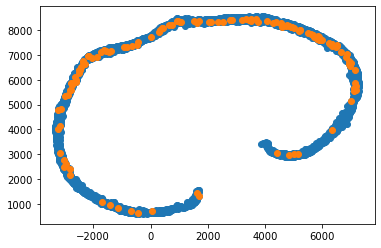

In [6]:

xy_table=pd.read_csv('data/Retina1.csv')

xcoords=[]
ycoords=[]
xy_Subtype=[]

xy_r11=xy_table[(xy_table.SectionNumber==1)]
xcoords=xy_r11.Remapped_X.values
ycoords=xy_r11.Remapped_Y.values
xy_Subtype= np.array(xy_r11.Subtype)

xy_Subtype_Shuffle=xy_Subtype.copy()
np.random.shuffle(xy_Subtype_Shuffle)
plt.figure()
plt.scatter(xcoords, ycoords)
plt.scatter(xcoords[xy_Subtype==1], ycoords[xy_Subtype==1])


 Computing appropriate shift and rotate values and applying them on the input coordinates. 


In [7]:

center_shift, theta_shift=coord_transfer(xcoords, ycoords)
center_shift_x=center_shift[0]
center_shift_y=center_shift[1]
xcoords=xcoords-center_shift_x
ycoords=ycoords-center_shift_y
xcoords_rot=(np.cos(theta_shift)*xcoords+np.sin(theta_shift)*ycoords)
ycoords_rot=(np.cos(theta_shift)*ycoords-np.sin(theta_shift)*xcoords)
zcoords=np.vstack((xcoords_rot, ycoords_rot)).T


 Computing polar coordinates of the input data, and sorting them based on their theta values.


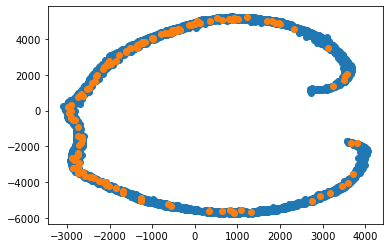

In [8]:

tvalo=np.mod(np.arctan2(ycoords_rot, xcoords_rot), 2*np.pi)

sidx=np.argsort(tvalo)
tvalo=tvalo[sidx]
rvalo=np.sqrt(ycoords_rot**2+xcoords_rot**2)
rvalo=rvalo[sidx]
xy_Subtype=xy_Subtype[sidx]
xcoords_rot=xcoords_rot[sidx]
ycoords_rot=ycoords_rot[sidx]
zcoords=zcoords[sidx, :]

plt.figure()
plt.scatter(zcoords[:,0], zcoords[:,1])
plt.scatter(zcoords[xy_Subtype==1][:,0], zcoords[xy_Subtype==1][:,1])



Straightening the knees at the beginning and the end of cell positions. 

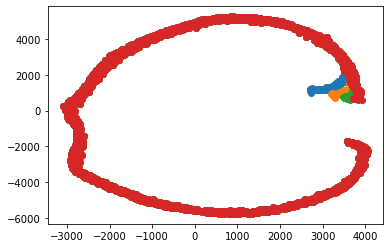

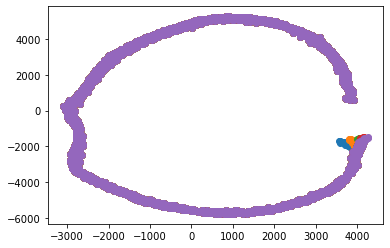

In [9]:
zcoords=unknee(zcoords)

tvalo=np.mod(np.arctan2(zcoords[:,1], zcoords[:,0]), 2*np.pi)
sidx=np.argsort(tvalo)
tvalo=tvalo[sidx]
xy_Subtype=xy_Subtype[sidx]
zcoords=zcoords[sidx, :]
xy_Subtype_Shuffle=xy_Subtype.copy()
np.random.shuffle(xy_Subtype_Shuffle)



Setting hyperparameters,

In [10]:
MI_Mode='Theta'   # use theta valuses for computing joint distribution
rand_bins=False   # Joint probability is computed at random theta values or equally spaced theta values
num_trials=1000   # number of values pdf is computed at. 
iter_max=100      # used to average results of the shuffled data

celltype1_vec=[1,2,14,15] # Target CellTypes that other cell types provide information about. 
num_celltype1=len(celltype1_vec)

if MI_Mode=='Theta':
    zcoords=tvalo[:,None]

Initializing required arrays and parameters, 

In [11]:
I_Rdncy_vec=[]
I21U_vec=[]
I31U_vec=[]
I_Snrgy_vec=[]
I231_vec=[]

IRand_Rdncy_vec=[]
IRand21U_vec=[]
IRand31U_vec=[]
IRand_Snrgy_vec=[]
IRand231_vec=[]

IRand_Rdncy_vec_t=[]
IRand21U_vec_t=[]
IRand31U_vec_t=[]
IRand_Snrgy_vec_t=[]
IRand231_vec_t=[]

IRand_Rdncy_vecs=0
IRand21U_vecs=0
IRand31U_vecs=0
IRand_Snrgy_vecs=0
IRand231_vecs=0

if rand_bins:
    tvalo_sliced=np.random.choice(tvalo[tvalo<tvalo[-1]], num_trials+1, replace=True)
    tvalo_sliced=np.sort(tvalo_sliced)
else:
    tvalo_sliced=np.linspace(tvalo[0], tvalo[-1], num_trials+1)
len123_vec=[]
type123_vec=[]


Computing PID for target celltype in celltype1_vec

In [12]:
for ii in celltype1_vec:
    zp1=zcoords[xy_Subtype==ii]

    len_ii=np.sum(xy_Subtype==ii)
    jjv=np.arange(1,16)
    jjv=jjv[jjv!=ii]

    for jj in jjv:
        zp2=zcoords[xy_Subtype==jj]
        len_jj=np.sum(xy_Subtype==jj)
        kkv=jjv.copy()
        kkv=kkv[kkv>jj]

        for kk in kkv:
                
            len_kk=np.sum(xy_Subtype==kk)
            zp3=zcoords[xy_Subtype==kk]
            cpos=[zp1, zp2, zp3]

            # Compute joint pdf    
            f3D_Real, pbins=joint_probability(cpos,p_bins=tvalo_sliced)
            # Compute PID valuse
            I_Rdncy, I21U, I31U, I_Snrgy, I23_1 =pid_compute(f3D_Real)
            
            I_Rdncy_vec=np.append(I_Rdncy_vec, I_Rdncy)
            I21U_vec=np.append(I21U_vec, I21U)
            I31U_vec=np.append(I31U_vec, I31U)
            I_Snrgy_vec=np.append(I_Snrgy_vec, I_Snrgy)
            I231_vec=np.append(I231_vec, I23_1)
            
            len_vec=np.array([len(zp1),len(zp2), len(zp3)])
            type_vec=np.array([ii,jj, kk])
            len123_vec=np.append(len123_vec,len_vec)
            type123_vec=np.append(type123_vec,type_vec)
            
    # Averaging for the Shuffled data
    for iter in range(iter_max):
        np.random.shuffle(xy_Subtype_Shuffle)
        for jj in jjv:
            kkv=jjv.copy()
            kkv=kkv[kkv>jj]
            np.random.shuffle(xy_Subtype_Shuffle)
            zp2_shufl=zcoords[xy_Subtype_Shuffle==jj]
            for kk in kkv:
                    

                np.random.shuffle(xy_Subtype_Shuffle)
                zp3_shufl=zcoords[xy_Subtype_Shuffle==kk]
                cpos_rand=[zp1, zp2_shufl, zp3_shufl]
                
                # Compute joint pdf   
                f3D_Rand, pbins=joint_probability(cpos_rand,p_bins=tvalo_sliced)
                # Compute PID valuse
                IRand_Rdncy, IRand21U, IRand31U, IRand_Snrgy, IRand23_1 =pid_compute(f3D_Rand)
                
                IRand_Rdncy_vec=np.append(IRand_Rdncy_vec, IRand_Rdncy)
                IRand21U_vec=np.append(IRand21U_vec, IRand21U)
                IRand31U_vec=np.append(IRand31U_vec, IRand31U)
                IRand_Snrgy_vec=np.append(IRand_Snrgy_vec, IRand_Snrgy)
                IRand231_vec=np.append(IRand231_vec, IRand23_1)



        IRand_Rdncy_vecs=IRand_Rdncy_vecs+IRand_Rdncy_vec
        IRand21U_vecs=IRand21U_vecs+IRand21U_vec
        IRand31U_vecs=IRand31U_vecs+IRand31U_vec
        IRand_Snrgy_vecs=IRand_Snrgy_vecs+IRand_Snrgy_vec
        IRand231_vecs=IRand231_vecs+IRand231_vec            
        IRand_Rdncy_vec=[]
        IRand21U_vec=[]
        IRand31U_vec=[]
        IRand_Snrgy_vec=[]
        IRand231_vec=[]

    IRand_Rdncy_vec_t=np.append(IRand_Rdncy_vec_t, IRand_Rdncy_vecs/iter_max)
    IRand21U_vec_t=np.append(IRand21U_vec_t, IRand21U_vecs/iter_max)
    IRand31U_vec_t=np.append(IRand31U_vec_t, IRand31U_vecs/iter_max)
    IRand_Snrgy_vec_t=np.append(IRand_Snrgy_vec_t, IRand_Snrgy_vecs/iter_max)
    IRand231_vec_t=np.append(IRand231_vec_t, IRand231_vecs/iter_max)        
    IRand_Rdncy_vecs=0
    IRand21U_vecs=0
    IRand31U_vecs=0
    IRand_Snrgy_vecs=0
    IRand231_vecs=0

    print('CellType 1 Number is ', ii) # Keeping track of the loop execution

CellType 1 Number is  1
CellType 1 Number is  2
CellType 1 Number is  14
CellType 1 Number is  15


# Plotting the Results

In [13]:

IRand_Rdncy_vec=IRand_Rdncy_vec_t
IRand21U_vec=IRand21U_vec_t
IRand31U_vec=IRand31U_vec_t
IRand_Snrgy_vec=IRand_Snrgy_vec_t
IRand231_vec=IRand231_vec_t

len1_vec=len123_vec[::3]
len2_vec=len123_vec[1::3]
len3_vec=len123_vec[2::3]

ctype1_vec=type123_vec[::3]
ctype2_vec=type123_vec[1::3]
ctype3_vec=type123_vec[2::3]

len1_vec=len1_vec.reshape([num_celltype1, -1])
len2_vec=len2_vec.reshape([num_celltype1, -1])
len3_vec=len3_vec.reshape([num_celltype1, -1])

ctype1_vec=ctype1_vec.reshape([num_celltype1, -1])
ctype2_vec=ctype2_vec.reshape([num_celltype1, -1])
ctype3_vec=ctype3_vec.reshape([num_celltype1, -1])

I_Rdncy_vec=I_Rdncy_vec.reshape([num_celltype1, -1])
I21U_vec=I21U_vec.reshape([num_celltype1, -1])
I31U_vec=I31U_vec.reshape([num_celltype1, -1])
I_Snrgy_vec=I_Snrgy_vec.reshape([num_celltype1, -1])
I231_vec=I231_vec.reshape([num_celltype1, -1])

IRand_Rdncy_vec=IRand_Rdncy_vec.reshape([num_celltype1, -1])
IRand21U_vec=IRand21U_vec.reshape([num_celltype1, -1])
IRand31U_vec=IRand31U_vec.reshape([num_celltype1, -1])
IRand_Snrgy_vec=IRand_Snrgy_vec.reshape([num_celltype1, -1])
IRand231_vec=IRand231_vec.reshape([num_celltype1, -1])



## Sort by Real Synergy


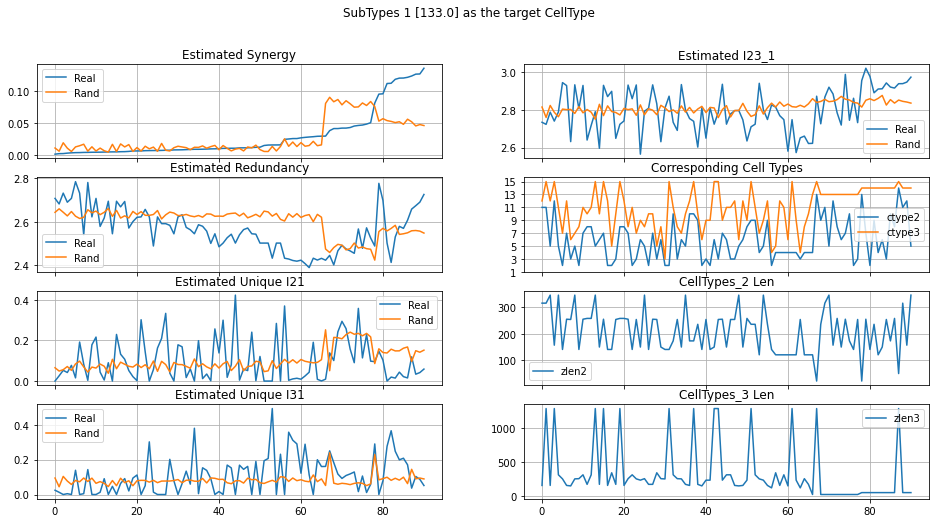

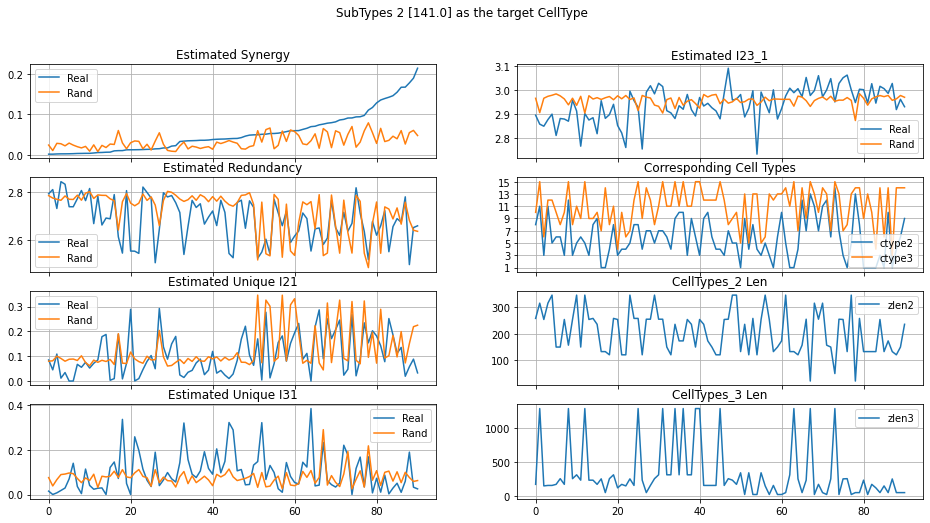

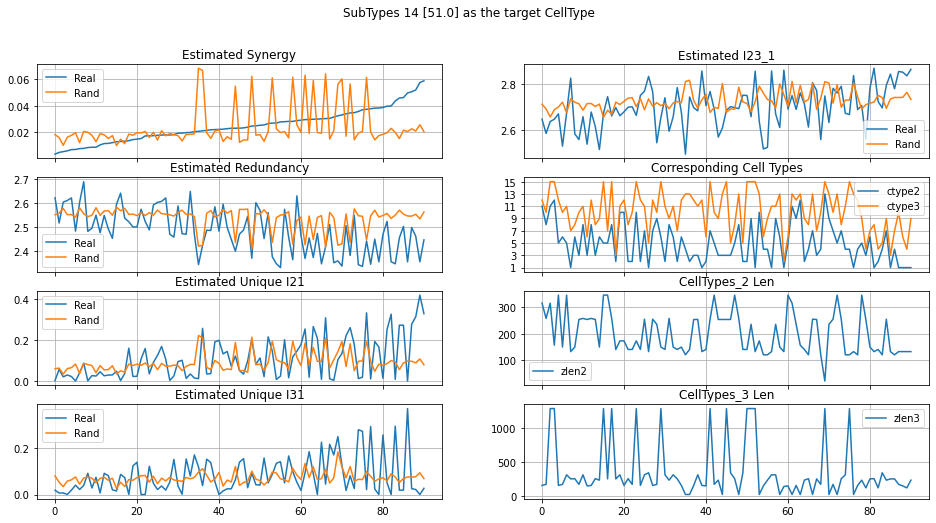

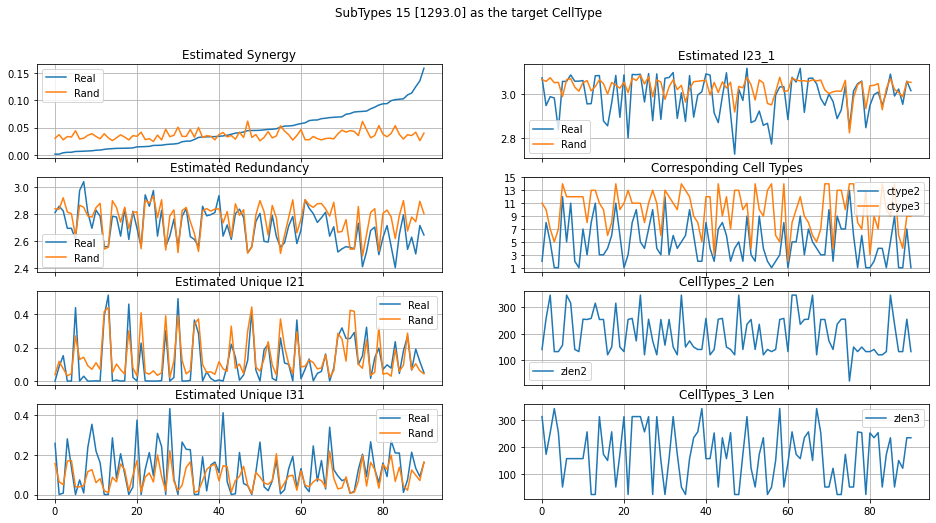

In [14]:
static_indices = np.indices(I_Rdncy_vec.shape)

sort_indices=np.argsort(I_Snrgy_vec, axis=1) 

I_Rdncy_vec=I_Rdncy_vec[static_indices[0],sort_indices]
I21U_vec=I21U_vec[static_indices[0],sort_indices]
I31U_vec=I31U_vec[static_indices[0],sort_indices]
I_Snrgy_vec=I_Snrgy_vec[static_indices[0],sort_indices]
I231_vec=I231_vec[static_indices[0],sort_indices]

IRand_Rdncy_vec=IRand_Rdncy_vec[static_indices[0],sort_indices]
IRand21U_vec=IRand21U_vec[static_indices[0],sort_indices]
IRand31U_vec=IRand31U_vec[static_indices[0],sort_indices]
IRand_Snrgy_vec=IRand_Snrgy_vec[static_indices[0],sort_indices]
IRand231_vec=IRand231_vec[static_indices[0],sort_indices]

len2_vec=len2_vec[static_indices[0],sort_indices]
len3_vec=len3_vec[static_indices[0],sort_indices]
ctype2_vec=ctype2_vec[static_indices[0],sort_indices]
ctype3_vec=ctype3_vec[static_indices[0],sort_indices]
for ii in range(num_celltype1):
    len1=len1_vec[ii,0]
    fig, axs = plt.subplots(4,2, figsize=(16,8),sharex=True)
    fig.suptitle('SubTypes '+ str(celltype1_vec[ii])+' [' + str(len1) +']'+' as the target CellType')
    axs[0,0].plot(I_Snrgy_vec[ii])
    axs[0,0].plot(IRand_Snrgy_vec[ii])
    axs[0,0].grid()
    axs[0,0].legend(['Real', 'Rand'])
    axs[0,0].set_title('Estimated Synergy')

    axs[1,0].plot(I_Rdncy_vec[ii])
    axs[1,0].plot(IRand_Rdncy_vec[ii])
    axs[1,0].grid()
    axs[1,0].legend(['Real', 'Rand'])
    axs[1,0].set_title('Estimated Redundancy')

    axs[2,0].plot(I21U_vec[ii])
    axs[2,0].plot(IRand21U_vec[ii])
    axs[2,0].grid()
    axs[2,0].legend(['Real', 'Rand'])
    axs[2,0].set_title('Estimated Unique I21')

    axs[3,0].plot(I31U_vec[ii])
    axs[3,0].plot(IRand31U_vec[ii])
    axs[3,0].grid()
    axs[3,0].legend(['Real', 'Rand'])
    axs[3,0].set_title('Estimated Unique I31')

    axs[0,1].plot(I231_vec[ii])
    axs[0,1].plot(IRand231_vec[ii])
    axs[0,1].grid()
    axs[0,1].legend(['Real', 'Rand'])
    axs[0,1].set_title('Estimated I23_1')


    axs[1,1].plot(ctype2_vec[ii])
    axs[1,1].plot(ctype3_vec[ii])
    axs[1,1].yaxis.set_ticks(np.arange(1, 16, 2.0))
    axs[1,1].grid()
    axs[1,1].legend(['ctype2', 'ctype3'])
    axs[1,1].set_title('Corresponding Cell Types')

    axs[2,1].plot(len2_vec[ii])
    axs[2,1].grid()
    axs[2,1].legend(['zlen2'])
    axs[2,1].set_title('CellTypes_2 Len')

    axs[3,1].plot(len3_vec[ii])
    axs[3,1].grid()
    axs[3,1].legend(['zlen3'])
    axs[3,1].set_title('CellTypes_3 Len')


## Sort by Random Synergy


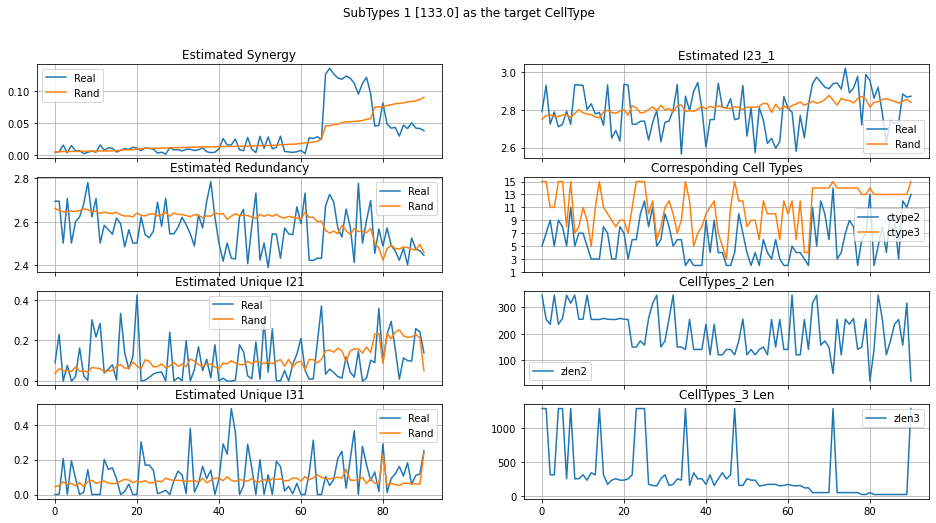

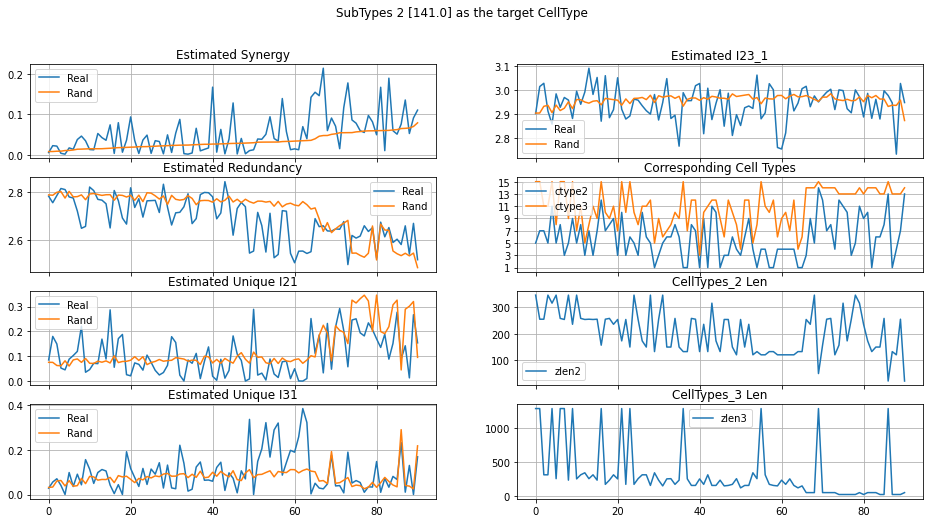

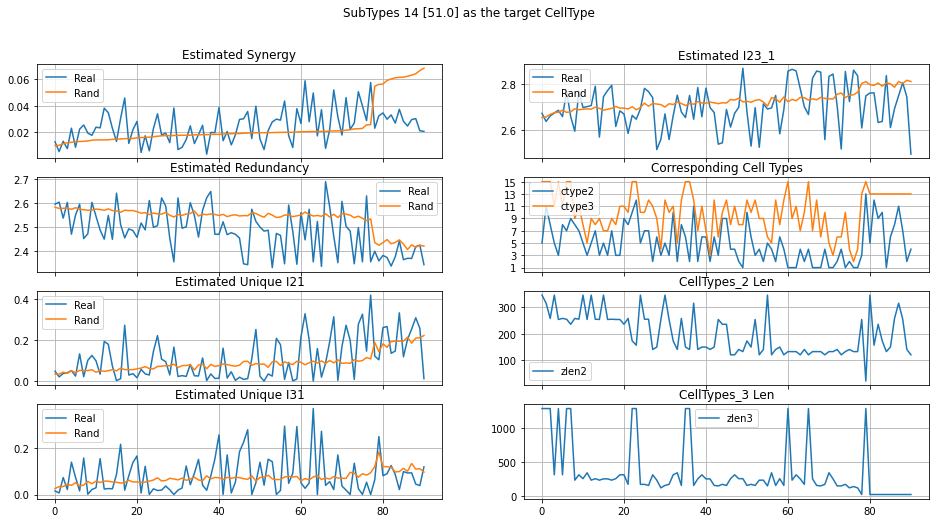

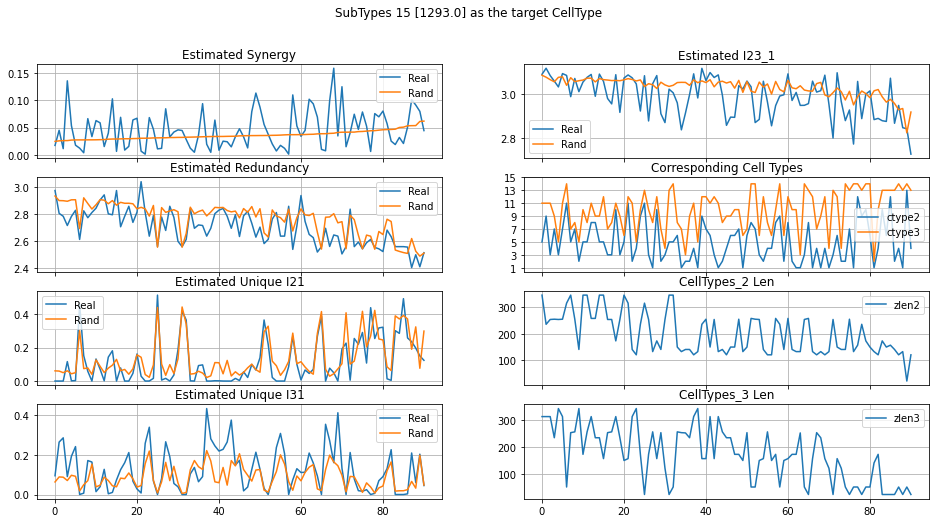

In [15]:


sort_indices=np.argsort(IRand_Snrgy_vec)
I_Rdncy_vec=I_Rdncy_vec[static_indices[0],sort_indices]
I31U_vec=I31U_vec[static_indices[0],sort_indices]
I21U_vec=I21U_vec[static_indices[0],sort_indices]
I_Snrgy_vec=I_Snrgy_vec[static_indices[0],sort_indices]
I231_vec=I231_vec[static_indices[0],sort_indices]


IRand_Rdncy_vec=IRand_Rdncy_vec[static_indices[0],sort_indices]
IRand21U_vec=IRand21U_vec[static_indices[0],sort_indices]
IRand31U_vec=IRand31U_vec[static_indices[0],sort_indices]
IRand_Snrgy_vec=IRand_Snrgy_vec[static_indices[0],sort_indices]
IRand231_vec=IRand231_vec[static_indices[0],sort_indices]


len2_vec=len2_vec[static_indices[0],sort_indices]
len3_vec=len3_vec[static_indices[0],sort_indices]
ctype2_vec=ctype2_vec[static_indices[0],sort_indices]
ctype3_vec=ctype3_vec[static_indices[0],sort_indices]

for ii in range(num_celltype1):

    len1=len1_vec[ii,0]
    fig, axs = plt.subplots(4,2,figsize=(16,8), sharex=True)
    fig.suptitle('SubTypes '+ str(celltype1_vec[ii])+' [' + str(len1) +']'+' as the target CellType')
    axs[0,0].plot(I_Snrgy_vec[ii])
    axs[0,0].plot(IRand_Snrgy_vec[ii])
    axs[0,0].grid()
    axs[0,0].legend(['Real', 'Rand'])
    axs[0,0].set_title('Estimated Synergy')

    axs[1,0].plot(I_Rdncy_vec[ii])
    axs[1,0].plot(IRand_Rdncy_vec[ii])
    axs[1,0].grid()
    axs[1,0].legend(['Real', 'Rand'])
    axs[1,0].set_title('Estimated Redundancy')

    axs[2,0].plot(I21U_vec[ii])
    axs[2,0].plot(IRand21U_vec[ii])
    axs[2,0].grid()
    axs[2,0].legend(['Real', 'Rand'])
    axs[2,0].set_title('Estimated Unique I21')

    axs[3,0].plot(I31U_vec[ii])
    axs[3,0].plot(IRand31U_vec[ii])
    axs[3,0].grid()
    axs[3,0].legend(['Real', 'Rand'])
    axs[3,0].set_title('Estimated Unique I31')



    axs[0,1].plot(I231_vec[ii])
    axs[0,1].plot(IRand231_vec[ii])
    axs[0,1].grid()
    axs[0,1].legend(['Real', 'Rand'])
    axs[0,1].set_title('Estimated I23_1')


    axs[1,1].plot(ctype2_vec[ii])
    axs[1,1].plot(ctype3_vec[ii])
    axs[1,1].yaxis.set_ticks(np.arange(1, 16, 2.0))
    axs[1,1].grid()
    axs[1,1].legend(['ctype2', 'ctype3'])
    axs[1,1].set_title('Corresponding Cell Types')


    axs[2,1].plot(len2_vec[ii])
    axs[2,1].grid()
    axs[2,1].legend(['zlen2'])
    axs[2,1].set_title('CellTypes_2 Len')

    axs[3,1].plot(len3_vec[ii])
    axs[3,1].grid()
    axs[3,1].legend(['zlen3'])
    axs[3,1].set_title('CellTypes_3 Len')




## Sort by Real I231


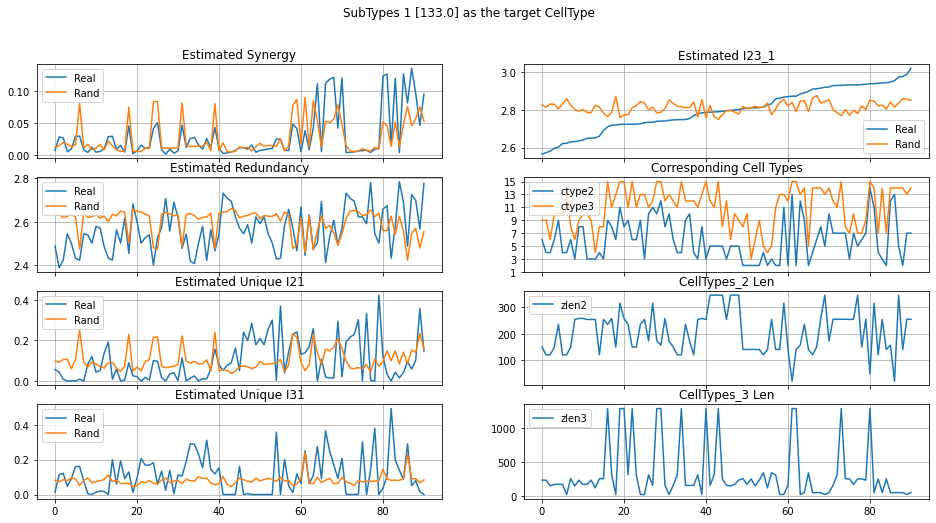

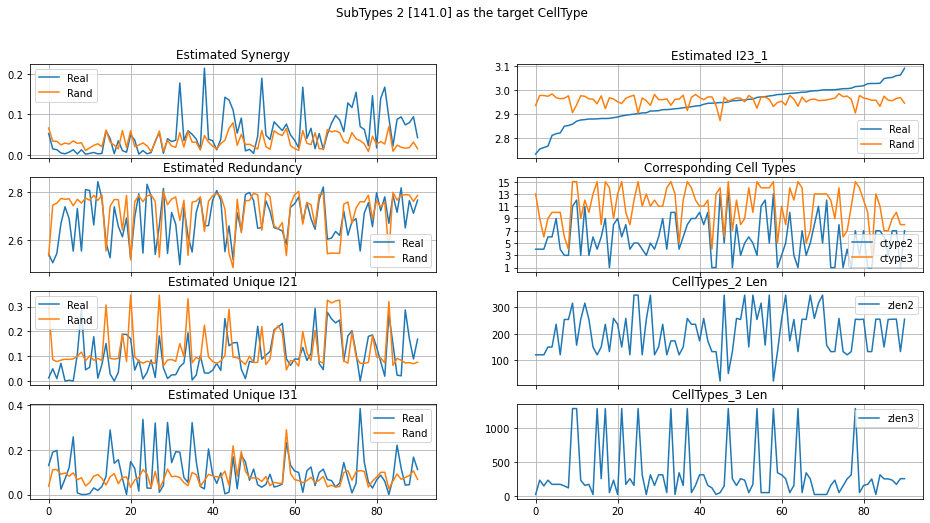

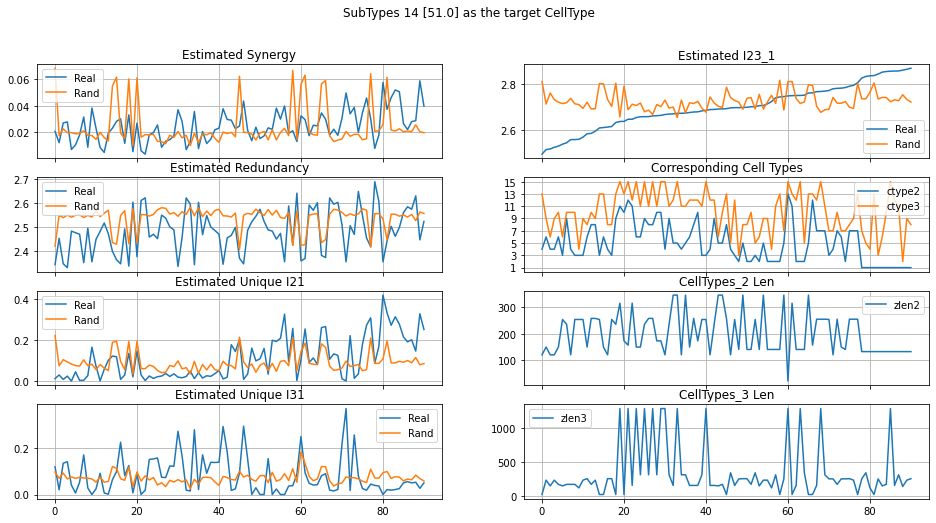

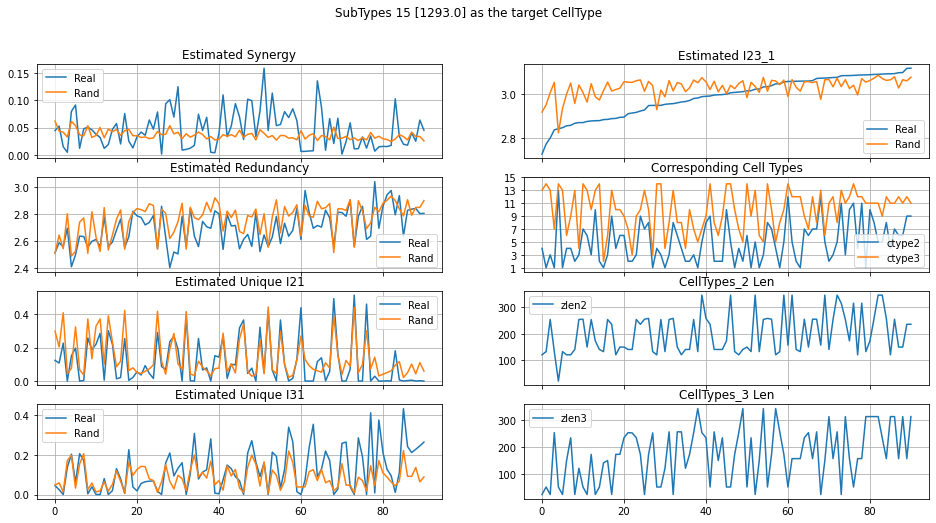

In [16]:

sort_indices=np.argsort(I231_vec)
I_Rdncy_vec=I_Rdncy_vec[static_indices[0],sort_indices]
I31U_vec=I31U_vec[static_indices[0],sort_indices]
I21U_vec=I21U_vec[static_indices[0],sort_indices]
I_Snrgy_vec=I_Snrgy_vec[static_indices[0],sort_indices]
I231_vec=I231_vec[static_indices[0],sort_indices]


IRand_Rdncy_vec=IRand_Rdncy_vec[static_indices[0],sort_indices]
IRand21U_vec=IRand21U_vec[static_indices[0],sort_indices]
IRand31U_vec=IRand31U_vec[static_indices[0],sort_indices]
IRand_Snrgy_vec=IRand_Snrgy_vec[static_indices[0],sort_indices]
IRand231_vec=IRand231_vec[static_indices[0],sort_indices]


len2_vec=len2_vec[static_indices[0],sort_indices]
len3_vec=len3_vec[static_indices[0],sort_indices]
ctype2_vec=ctype2_vec[static_indices[0],sort_indices]
ctype3_vec=ctype3_vec[static_indices[0],sort_indices]

for ii in range(num_celltype1):
    len1=len1_vec[ii,0]
    fig, axs = plt.subplots(4,2,figsize=(16,8), sharex=True)
    fig.suptitle('SubTypes '+ str(celltype1_vec[ii])+' [' + str(len1) +']' +' as the target CellType')
    axs[0,0].plot(I_Snrgy_vec[ii])
    axs[0,0].plot(IRand_Snrgy_vec[ii])
    axs[0,0].grid()
    axs[0,0].legend(['Real', 'Rand'])
    axs[0,0].set_title('Estimated Synergy')

    axs[1,0].plot(I_Rdncy_vec[ii])
    axs[1,0].plot(IRand_Rdncy_vec[ii])
    axs[1,0].grid()
    axs[1,0].legend(['Real', 'Rand'])
    axs[1,0].set_title('Estimated Redundancy')

    axs[2,0].plot(I21U_vec[ii])
    axs[2,0].plot(IRand21U_vec[ii])
    axs[2,0].grid()
    axs[2,0].legend(['Real', 'Rand'])
    axs[2,0].set_title('Estimated Unique I21')

    axs[3,0].plot(I31U_vec[ii])
    axs[3,0].plot(IRand31U_vec[ii])
    axs[3,0].grid()
    axs[3,0].legend(['Real', 'Rand'])
    axs[3,0].set_title('Estimated Unique I31')



    axs[0,1].plot(I231_vec[ii])
    axs[0,1].plot(IRand231_vec[ii])
    axs[0,1].grid()
    axs[0,1].legend(['Real', 'Rand'])
    axs[0,1].set_title('Estimated I23_1')


    axs[1,1].plot(ctype2_vec[ii])
    axs[1,1].plot(ctype3_vec[ii])
    axs[1,1].yaxis.set_ticks(np.arange(1, 16, 2.0))
    axs[1,1].grid()
    axs[1,1].legend(['ctype2', 'ctype3'])
    axs[1,1].set_title('Corresponding Cell Types')

    axs[2,1].plot(len2_vec[ii])
    axs[2,1].grid()
    axs[2,1].legend(['zlen2'])
    axs[2,1].set_title('CellTypes_2 Len')

    axs[3,1].plot(len3_vec[ii])
    axs[3,1].grid()
    axs[3,1].legend(['zlen3'])
    axs[3,1].set_title('CellTypes_3 Len')



## Sort by Id_Snrgy, difference between real and shuffled synergy


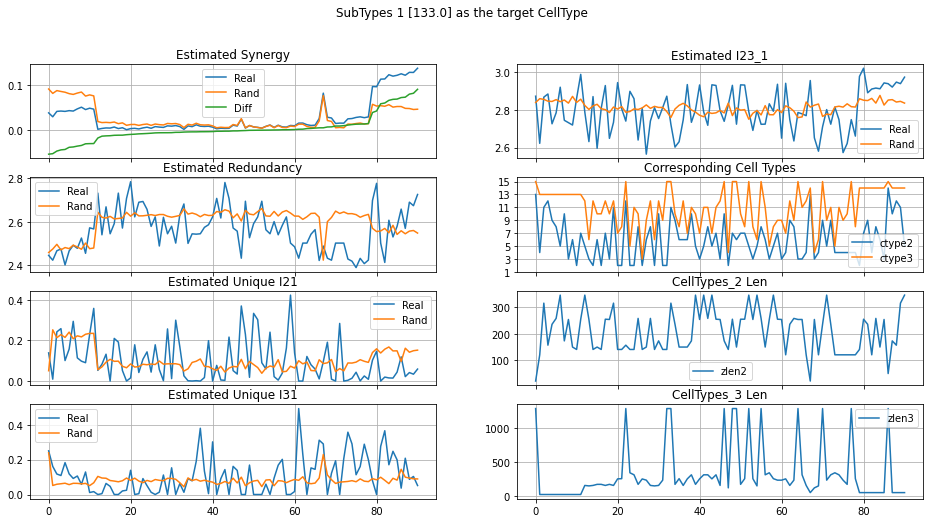

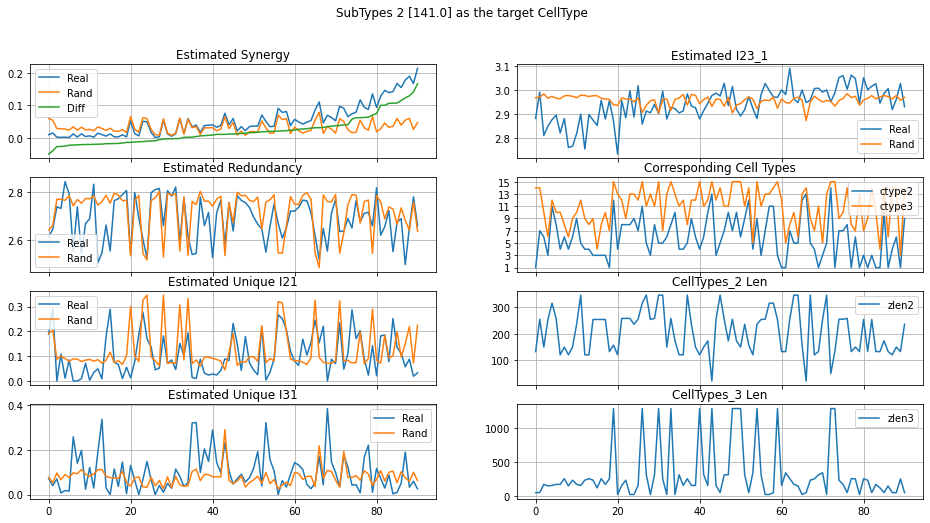

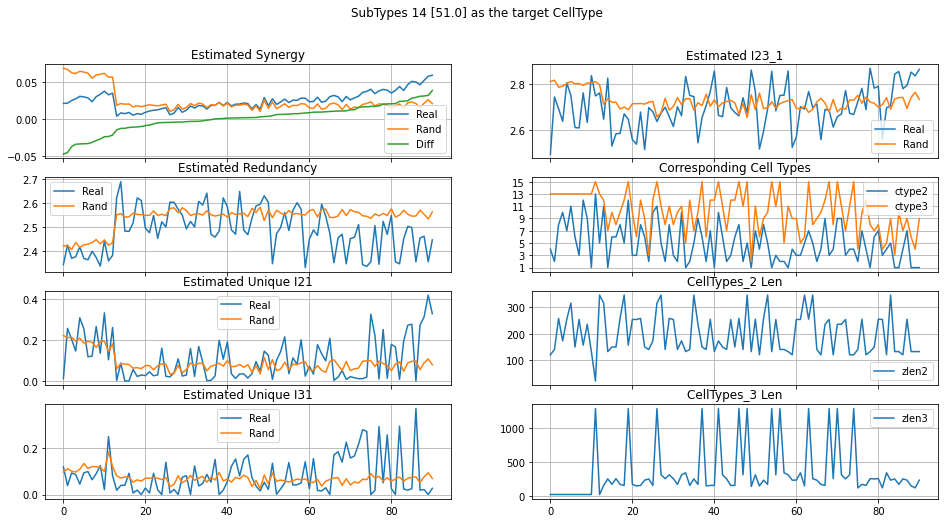

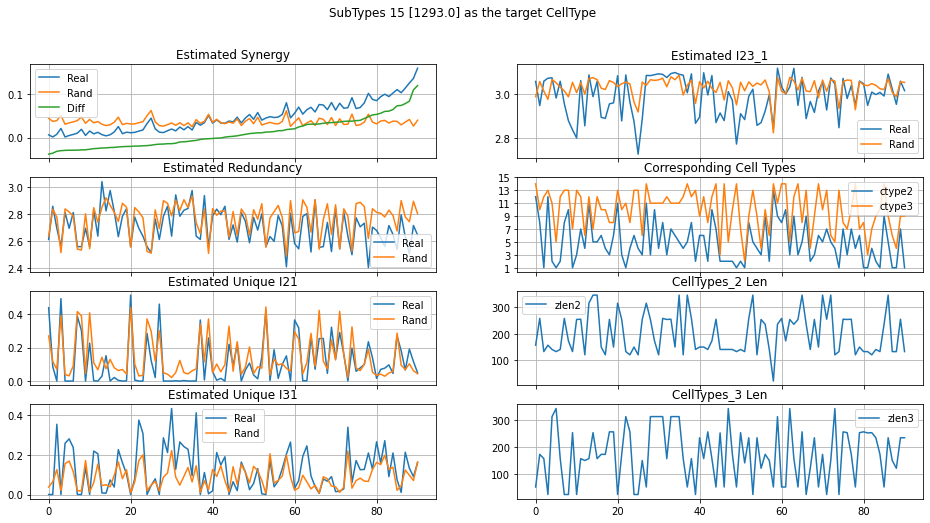

In [17]:
Id_Snrgy=I_Snrgy_vec-IRand_Snrgy_vec

sort_indices=np.argsort(Id_Snrgy)
I_Rdncy_vec=I_Rdncy_vec[static_indices[0],sort_indices]
I31U_vec=I31U_vec[static_indices[0],sort_indices]
I21U_vec=I21U_vec[static_indices[0],sort_indices]
I_Snrgy_vec=I_Snrgy_vec[static_indices[0],sort_indices]
I231_vec=I231_vec[static_indices[0],sort_indices]


IRand_Rdncy_vec=IRand_Rdncy_vec[static_indices[0],sort_indices]
IRand21U_vec=IRand21U_vec[static_indices[0],sort_indices]
IRand31U_vec=IRand31U_vec[static_indices[0],sort_indices]
IRand_Snrgy_vec=IRand_Snrgy_vec[static_indices[0],sort_indices]
IRand231_vec=IRand231_vec[static_indices[0],sort_indices]
Id_Snrgy=Id_Snrgy[static_indices[0],sort_indices]

len2_vec=len2_vec[static_indices[0],sort_indices]
len3_vec=len3_vec[static_indices[0],sort_indices]
ctype2_vec=ctype2_vec[static_indices[0],sort_indices]
ctype3_vec=ctype3_vec[static_indices[0],sort_indices]

for ii in range(num_celltype1):
    len1=len1_vec[ii,0]
    fig, axs = plt.subplots(4,2, figsize=(16,8),sharex=True)
    fig.suptitle('SubTypes '+ str(celltype1_vec[ii])+' [' + str(len1) +']' +' as the target CellType')
    axs[0,0].plot(I_Snrgy_vec[ii])
    axs[0,0].plot(IRand_Snrgy_vec[ii])
    axs[0,0].plot(Id_Snrgy[ii])
    axs[0,0].grid()
    axs[0,0].legend(['Real', 'Rand', 'Diff'])
    axs[0,0].set_title('Estimated Synergy')

    axs[1,0].plot(I_Rdncy_vec[ii])
    axs[1,0].plot(IRand_Rdncy_vec[ii])
    axs[1,0].grid()
    axs[1,0].legend(['Real', 'Rand'])
    axs[1,0].set_title('Estimated Redundancy')

    axs[2,0].plot(I21U_vec[ii])
    axs[2,0].plot(IRand21U_vec[ii])
    axs[2,0].grid()
    axs[2,0].legend(['Real', 'Rand'])
    axs[2,0].set_title('Estimated Unique I21')

    axs[3,0].plot(I31U_vec[ii])
    axs[3,0].plot(IRand31U_vec[ii])
    axs[3,0].grid()
    axs[3,0].legend(['Real', 'Rand'])
    axs[3,0].set_title('Estimated Unique I31')



    axs[0,1].plot(I231_vec[ii])
    axs[0,1].plot(IRand231_vec[ii])
    axs[0,1].grid()
    axs[0,1].legend(['Real', 'Rand'])
    axs[0,1].set_title('Estimated I23_1')


    axs[1,1].plot(ctype2_vec[ii])
    axs[1,1].plot(ctype3_vec[ii])
    axs[1,1].yaxis.set_ticks(np.arange(1, 16, 2.0))
    axs[1,1].grid()
    axs[1,1].legend(['ctype2', 'ctype3'])
    axs[1,1].set_title('Corresponding Cell Types')

    axs[2,1].plot(len2_vec[ii])
    axs[2,1].grid()
    axs[2,1].legend(['zlen2'])
    axs[2,1].set_title('CellTypes_2 Len')

    axs[3,1].plot(len3_vec[ii])
    axs[3,1].grid()
    axs[3,1].legend(['zlen3'])
    axs[3,1].set_title('CellTypes_3 Len')




check=1